# Exploration of US healthcare spend 
# Data cleaning

right now everything is in one notebook, but will be separated into to

---

## Import tools 

In [1]:
import requests
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ipywidgets as widget
import string

## 1. Clean and explore the data for hospital charges and payments

In [2]:
# Import my data into a 'c' costs dictionary of dataframes, keyed for each year
c={}
my_years = [2011, 2012, 2013, 2014, 2015, 2016, 2017]
for yr in my_years:
    c[yr] = pd.read_csv(f'./data/costs/costs_{yr}.csv')

In [3]:
c[2011].head(2)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71


In [4]:
# clean my data
for yr in my_years:
    # for every df in my dictionary, change the col names, annotate the years
    c[yr].columns = ['diagnosis', 'id', 'name','address','city','state','zip','region',
       f'ave_discharged_{yr}', f'ave_charged_{yr}', f'ave_paid_{yr}', f'ave_medicare_{yr}']
    
    # drop cols I won't be using
    c[yr].drop(columns = ['id', 'name', 'address', 'city', 'zip', 'region'],inplace= True)
    
    # truncate our Diagnosis Related Group description to 3 digit string
    c[yr].diagnosis = c[yr].diagnosis.str[0:3]
    
    # We drop DC as a state
    c[yr].drop(c[yr][c[yr]['state'] == 'DC'].index, inplace=True)    
 
    # Let's consolidate all the state data by diagnosis, and get the mean of what each state charges/ is paid
    c[yr]=c[yr].groupby(['state','diagnosis'],as_index=False).mean()


    # Engineer/ add feature = this col compares the cost of a procedure vs what medicare pays
    c[yr][f'charge_over_med_{yr}'] = (c[yr][f'ave_charged_{yr}'] - c[yr][f'ave_medicare_{yr}']
                                     ) / c[yr][f'ave_medicare_{yr}']

    # this col compares the average amount paid for a procedure vs what medicare pays
    c[yr][f'paid_over_med_{yr}'] = (c[yr][f'ave_paid_{yr}'] - c[yr][f'ave_medicare_{yr}']
                                     ) / c[yr][f'ave_medicare_{yr}']             
    
    # Interesting ovservation - number of recorded DRGs wen up from 100 to 560+
    print(f'YR={yr}, SHAPE={c[yr].shape}, STATES={len(c[yr].state.unique())},  DIAGNOSES={len(c[yr].diagnosis.unique())}')
    
print('Summy of dictionary with yearly healthcare charge and payment data')

YR=2011, SHAPE=(4925, 8), STATES=50,  DIAGNOSES=100
YR=2012, SHAPE=(4939, 8), STATES=50,  DIAGNOSES=100
YR=2013, SHAPE=(4937, 8), STATES=50,  DIAGNOSES=100
YR=2014, SHAPE=(14809, 8), STATES=50,  DIAGNOSES=564
YR=2015, SHAPE=(15024, 8), STATES=50,  DIAGNOSES=563
YR=2016, SHAPE=(15239, 8), STATES=50,  DIAGNOSES=573
YR=2017, SHAPE=(15223, 8), STATES=50,  DIAGNOSES=563
Summy of dictionary with yearly healthcare charge and payment data


In [5]:
# We me merge all the years into one dataframe
# data is merged on the State and the diagnosis (DRG)
merge1 = c[2011].merge(c[2012], on=['state','diagnosis'])
print(merge1.shape)

merge2 = merge1.merge(c[2013], on=['state','diagnosis'])
print(merge2.shape)

merge3 = merge2.merge(c[2014], on=['state','diagnosis'])
print(merge3.shape)

merge4 = merge3.merge(c[2015], on=['state','diagnosis'])
print(merge4.shape)

merge5 = merge4.merge(c[2016], on=['state','diagnosis'])
print(merge5.shape)

merge6 = merge5.merge(c[2017], on=['state','diagnosis'])
print(merge6.shape)


(4819, 14)
(4659, 20)
(4641, 26)
(4582, 32)
(4494, 38)
(4468, 44)


In [6]:
# Data is merged on the state and diagnosis
# We have 93 diagnoses common to all 50 states and 7 years in our data.
common_diagnoses=(np.unique(merge6.diagnosis))
len(common_diagnoses)

93

In [7]:
#create new col representing BOTH STATE and diagnosis
merge6['STdiag']=merge6.state+merge6.diagnosis
merge6.drop(columns = ['state', 'diagnosis'],inplace= True)
merge6 = merge6.set_index('STdiag')
#drop old cols and make new col the index

#Transpose so data resembles a time series
data = merge6.T
data=data.reset_index()
data.rename(columns = {'index':'ave_data'}, inplace = True)

# Create a new COL which creates the median for all states and all procedures
data['USall'] = data.median(axis=1)

#create new cols for STATE median for all 93 procedures
my_states = ['AK','AL','AR','AZ','CA','CO','CT','DE','FL','GA','HI','IA','ID',
             'IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO','MS',
             'MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA',
             'RI','SC','SD','TN','TX','UT','VA','VT','WA','WI','WV','WY']
for st in my_states:
    data[f'{st}all']= data.filter(like= st).median(axis=1)

   
data.head()

STdiag,ave_data,AK039,AK064,AK065,AK066,AK101,AK176,AK177,AK189,AK190,...,SDall,TNall,TXall,UTall,VAall,VTall,WAall,WIall,WVall,WYall
0,ave_discharged_2011,23.000000,22.500000,25.333333,21.000000,19.500000,26.00000,14.500000,24.000000,23.285714,...,27.583333,33.758621,29.789474,22.000000,30.321429,29.500000,25.833333,25.259259,29.052632,22.000000
1,ave_charged_2011,34805.130000,42453.810000,32629.370000,25843.322500,23156.085000,35672.65000,61224.635000,45137.093333,33169.691429,...,24257.994667,22918.886066,32769.518395,19871.853636,22399.921905,16199.150000,24974.775171,20396.486364,15737.700714,23809.538750
2,ave_paid_2011,8401.950000,21608.010000,12555.548333,9275.867500,7682.735000,10349.50000,16333.210000,11854.953333,13414.714286,...,7916.021571,6612.036250,7560.220311,7792.068333,7223.536222,9888.220000,8030.231872,7594.615577,6789.610769,9873.196250
3,ave_medicare_2011,6413.780000,20555.255000,11140.963333,8258.427500,5942.060000,7460.65000,15395.450000,10847.556667,12098.165714,...,6597.558810,5535.923958,6333.127486,6163.990714,5938.415373,8684.030000,6670.433453,6105.764259,5772.969091,8403.470625
4,charge_over_med_2011,4.426617,1.065351,1.928775,2.129327,2.896979,3.78144,2.976801,3.161038,1.741712,...,2.412167,3.303860,4.320847,2.192585,3.001546,0.927788,2.919880,2.274726,1.821586,1.979725


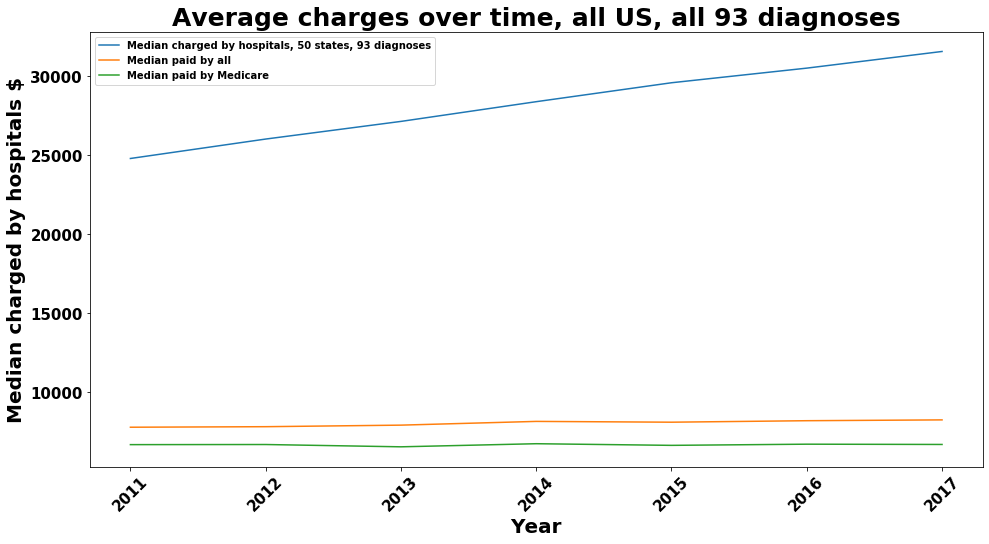

In [8]:
# Let's look at how US healthcare costs look over time, 93 common diagnoses
# This is amount charged over time, for all of US

y1 = data[data['ave_data'].str.contains("ave_charged")]['USall']
y2 = data[data['ave_data'].str.contains("ave_paid")]['USall']
y3 = data[data['ave_data'].str.contains("ave_medicare")]['USall']

plt.figure(figsize=(16,8))
plt.title('Average charges over time, all US, all 93 diagnoses', fontsize = 25)
plt.plot(my_years, y1, label = 'Median charged by hospitals, 50 states, 93 diagnoses')
plt.plot(my_years, y2, label = 'Median paid by all')
plt.plot(my_years, y3, label = 'Median paid by Medicare')
plt.xlabel('Year',fontsize=20)
plt.ylabel('Median charged by hospitals $',fontsize=20)
plt.xticks(my_years,fontsize=15, rotation = 45)
plt.yticks(fontsize=15)
plt.legend(loc='best');


In [9]:
# Lets look at charges and payments for individual states
def my_statecost1(state1):
    
    y = data[data['ave_data'].str.contains("ave_paid")][f'{state1}all']
    y2 = data[data['ave_data'].str.contains("ave_medicare")][f'{state1}all']
    y3 = data[data['ave_data'].str.contains("ave_charged")][f'{state1}all']
    
    plt.figure(figsize=(16,8))
    plt.title(f'Hospital charges and payments in {state1} (median of 93 diagnoses)', fontsize=25)
    plt.plot(my_years, y3,label = 'Median charge for diagnoses')
    plt.plot(my_years, y, label = 'Median payment by all')
    plt.plot(my_years, y2,label = 'Median payment by Medicare')
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Charged by/ Paid to hospitals($)',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    

state_slider1 = widget.SelectionSlider(
    options=my_states,
    value='AK',
    description='State:',
    orientation='horizontal'
    )


widget.interact(my_statecost1 , state1=state_slider1)        

interactive(children=(SelectionSlider(description='State:', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT',…

<function __main__.my_statecost1(state1)>

In [10]:
def my_statecost2(state2,diagnosis_choice):
    plt.figure(figsize=(16,8))
    plt.title(f'How much hospitals in {state2} charge for procedure {diagnosis_choice}', fontsize=25)
    
    y = data[data['ave_data'].str.contains("ave_charged")][f'{state2}{diagnosis_choice}']
    y2 = data[data['ave_data'].str.contains("ave_paid")][f'{state2}{diagnosis_choice}']
    y3 = data[data['ave_data'].str.contains("ave_medicare")][f'{state2}{diagnosis_choice}']
    
    plt.plot(my_years, y, label = 'Median charged by hospital ')
    plt.plot(my_years, y2,label = 'Median payment by all')
    plt.plot(my_years, y3,label = 'Median payment by Medicare')  
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Charged by/ Paid to hospitals($)',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
state_slider2 = widget.SelectionSlider(
    options=my_states,
    value='CO',
    description='State:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
    )

diagnosis_slider = widget.SelectionSlider(
    options=common_diagnoses,
    value='039',
    description='Diagnosis code:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
    )

widget.interact(my_statecost2, state2=state_slider2, diagnosis_choice=diagnosis_slider)        


interactive(children=(SelectionSlider(continuous_update=False, description='State:', index=5, options=('AK', '…

<function __main__.my_statecost2(state2, diagnosis_choice)>

In [11]:
def my_statcosts3(state3,state4):
    plt.figure(figsize=(16,8))
    plt.title(f'Comparing hospital charges and payments in {state3} and {state4} (93 diagnoses)', fontsize=25)
 
    y1= data[data['ave_data'].str.contains("ave_charged")][f'{state3}all']
    y2 = data[data['ave_data'].str.contains("ave_paid")][f'{state3}all']
    y3 = data[data['ave_data'].str.contains("ave_medicare")][f'{state3}all']
    
    y4 = data[data['ave_data'].str.contains("ave_charged")][f'{state4}all']
    y5 = data[data['ave_data'].str.contains("ave_paid")][f'{state4}all']
    y6 = data[data['ave_data'].str.contains("ave_medicare")][f'{state4}all']    
    
    plt.plot(my_years, y1,
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state3} Median charge for diagnosis')
    plt.plot(my_years, y2,
             color = 'green',
             linestyle = 'dashed',
             marker = '^',
             label = f'{state3} Median payment by all')
    plt.plot(my_years, y3,
             color = 'darkgreen',
             linestyle = 'solid',
             marker = 's',
             label = f'{state3} Median payment by Medicare')
    
    plt.plot(my_years, y4,
             color = 'orange',
             linestyle = 'dotted',
             marker = 'o',             
             label = f'{state4} Median charge for diagnosis')
    plt.plot(my_years, y5,
             color = 'red',
             linestyle = 'dashed',
             marker = '^',
             label = f'{state4} Median payment by all')
    plt.plot(my_years, y6,
             color = 'darkred',
             linestyle = 'solid',
             marker = 's',
             label = f'{state4} Median payment by Medicare')     
                                                                                                                            
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Paid to hospitals',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
state_select3 = widget.Select(
    options=my_states,
    value='AL',
    description='State1:'
    )
    
state_select4 = widget.Select(
    options=my_states,
    value='CT',
    description='State2:'
    )    

widget.interact(my_statcosts3, state3=state_select3, state4= state_select4)   

interactive(children=(Select(description='State1:', index=1, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT'…

<function __main__.my_statcosts3(state3, state4)>

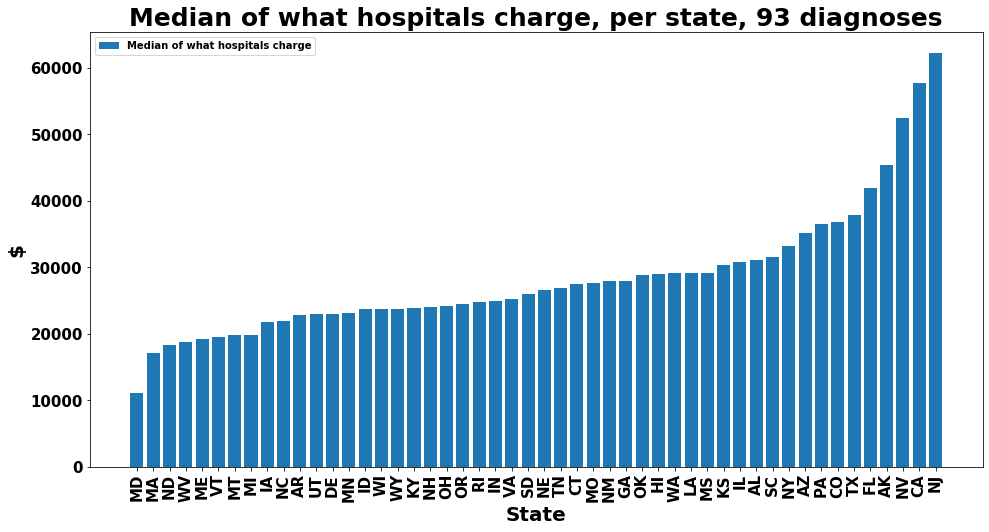

In [12]:
# PLOT which states charge the most

x1=[]
for st in my_states:
    x1.append([st , data[data['ave_data'].str.contains("ave_charged")][f'{st}all'].mean()])
   
x1= pd.DataFrame(x1)
x1.sort_values(by = [1], inplace = True)

plt.figure(figsize=(16,8))
plt.title('Median of what hospitals charge, per state, 93 diagnoses', fontsize = 25)
plt.bar( x1[0], x1[1], label = 'Median of what hospitals charge')
plt.xlabel('State',fontsize=20)
plt.ylabel('$',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


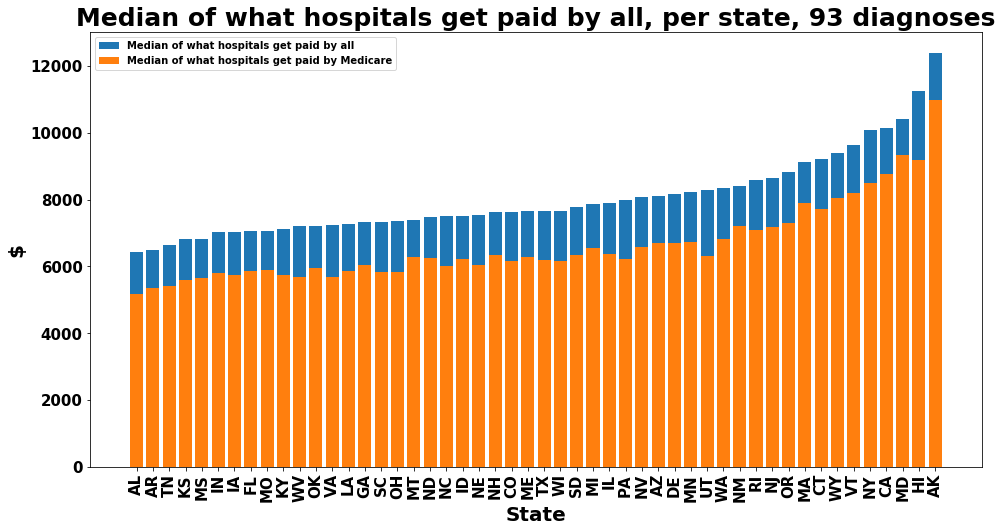

In [13]:
# PLOT which states get paid the 

x2 = []
for st in my_states:
    x2.append([st , data[data['ave_data'].str.contains("ave_paid")][f'{st}all'].mean()])
   
x3 =[]
for st in my_states:
    x3.append([st , data[data['ave_data'].str.contains("ave_medicare")][f'{st}all'].mean()])
   
x2 = pd.DataFrame(x2)
x3 = pd.DataFrame(x3)

x4 = x2.merge(x3, on = 0)
x4.sort_values(by = ['1_x'], inplace = True)

plt.figure(figsize=(16,8))
plt.title('Median of what hospitals get paid by all, per state, 93 diagnoses', fontsize = 25)
plt.bar( x4[0], x4['1_x'], label = 'Median of what hospitals get paid by all')
plt.bar( x4[0], x4['1_y'], label = 'Median of what hospitals get paid by Medicare')
plt.xlabel('State',fontsize=20)
plt.ylabel('$',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


In [14]:
##########
# Correlation of Medicare payments vs all payments

x = data[data['ave_data'].str.contains("ave_paid")]['USall']
y = data[data['ave_data'].str.contains("ave_medicare")]['USall']
scipy.stats.pearsonr(x, y)


(0.346708747027121, 0.44613798155651485)

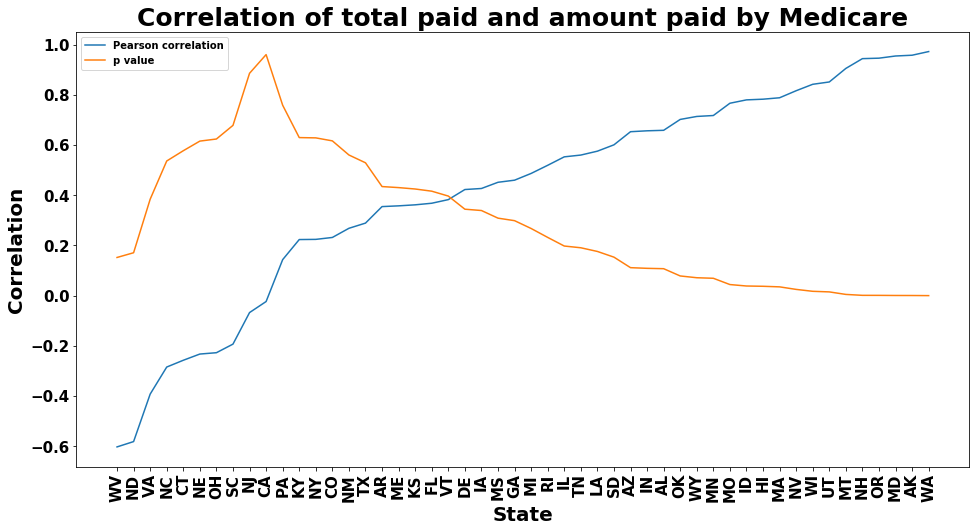

In [15]:
# calculate Pearson correlation
pc = {}
pp = {}
for state in my_states:
    x = data[data['ave_data'].str.contains("ave_paid")][f'{state}all']
    y = data[data['ave_data'].str.contains("ave_medicare")][f'{state}all']
    pc[state] = scipy.stats.pearsonr(x, y)[0]
    pp[state] = scipy.stats.pearsonr(x, y)[1]
    
p_corr = pd.DataFrame([pc,pp]).T
p_corr.rename(columns ={0:'corr', 1:'pvalue'}, inplace=True)
p_corr.sort_values(by=['corr'], inplace=True)

# PLOT correlation
plt.figure(figsize=(16,8))
plt.title('Correlation of total paid and amount paid by Medicare', fontsize = 25)
plt.plot(p_corr['corr'], label = 'Pearson correlation')
plt.plot(p_corr.pvalue, label = 'p value')
plt.xlabel('State',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


# calculate Spearman correlation
sc = {}
sp = {}
for state in my_states:
    x = data[data['ave_data'].str.contains("ave_paid")][f'{state}all']
    y = data[data['ave_data'].str.contains("ave_medicare")][f'{state}all']
    sc[state] = scipy.stats.spearmanr(x, y)[0]
    sp[state] = scipy.stats.spearmanr(x, y)[1]
    
sp_corr = pd.DataFrame([sc,sp]).T
sp_corr.rename(columns ={0:'corr', 1:'pvalue'}, inplace=True)
sp_corr.sort_values(by=['corr'], inplace=True)

# PLOT correlation
plt.figure(figsize=(16,8))
plt.title('Correlation of total paid and amount paid by Medicare', fontsize = 25)
plt.plot(sp_corr['corr'], label = 'Spearman correlation')
plt.plot(sp_corr.pvalue, label = 'p value')
plt.xlabel('State',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');

# calculate Pearson correlation for diagnoses
pcd = {}
ppd = {}
for diagnosis in common_daignoses:
    x = data[data['ave_data'].str.contains("ave_paid")][f'{state}all']
    y = data[data['ave_data'].str.contains("ave_medicare")][f'{state}all']
    pc[state] = scipy.stats.pearsonr(x, y)[0]
    pp[state] = scipy.stats.pearsonr(x, y)[1]
    
p_corr = pd.DataFrame([pc,pp]).T
p_corr.rename(columns ={0:'corr', 1:'pvalue'}, inplace=True)
p_corr.sort_values(by=['corr'], inplace=True)

# PLOT correlation
plt.figure(figsize=(16,8))
plt.title('Correlation of total paid and amount paid by Medicare', fontsize = 25)
plt.plot(p_corr['corr'], label = 'Pearson correlation')
plt.plot(p_corr.pvalue, label = 'p value')
plt.xlabel('State',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


## 2. Clean and explore lobbying data

### Read in US population data, from 2010 Census

In [16]:
# No additional cleaning needed
pop=pd.read_csv('./data/states/population.csv')
pop.head()

,state,population
0,AL,4779736
1,AK,710231
2,AZ,6392017
3,AR,2915918
4,CA,37253956


### Read in and clean Lobby Disclosure Act reports

In [17]:
# Import my data into 's' states dictionary of dataframes, keyed for each state
s={}
for st in my_states:
    s[st] = pd.read_csv(f'./data/states/{st}.csv')

In [18]:
s['AL'].head(5)

,State,Registrant Name,Client Name,Filing Type,Amount Reported,Date Posted,Filing Year
0,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,FOURTH QUARTER REPORT,"$10,000.00",1/17/2020,2019
1,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,FOURTH QUARTER REPORT,"$15,000.00",1/30/2019,2018
2,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,FIRST QUARTER REPORT,"$15,000.00",4/17/2019,2019
3,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,SECOND QUARTER REPORT,"$15,000.00",7/18/2019,2019
4,AL,"Acadian Advantage, LLC",Bob Riley and Associates on behalf of HPC Spec...,THIRD QUARTER AMENDMENT,"$15,000.00",10/23/2018,2018


In [19]:
for st in my_states:
    # for every df in my dictionary, change the col names
    s[st].columns = ['state', 'lobbyist', 'client','report','amount','date','year']
    
    # if there is an AMENDMENT report, keep the latest AMENDMENT and discard the previous REPORT
    # to do this we have to create a new col to help with identifying duplicates
    s[st]['date'] = pd.to_datetime(s[st]['date'])
    s[st].sort_values(by=['date'], inplace = True)
    s[st]['period'] = (s[st]['report'].str.split().str[:-1])
    s[st]['period'] = s[st]['period'].map(lambda val: ' '.join(val))
    s[st] = s[st].drop_duplicates(subset = ['state','client', 'year', 'period'],keep = 'last')    
        
    # remove all the nuls
    # this removes all 'REGISTRATION', 'TERMINATION', other reports with no reported amounts
    s[st].dropna(inplace=True)    

    # drop cols I won't be using
    s[st].drop(columns = ['lobbyist', 'date','period'],inplace= True)

    # convert money to float
    s[st].amount = s[st].amount.str.replace('$','')
    s[st].amount = s[st].amount.str.replace(',','')
    s[st].amount = s[st].amount.str.replace(' ','')
    s[st].amount = s[st].amount.astype(float)    
 
    # sum amount by state and year
    s[st]=s[st].groupby(['year'],as_index=False).sum()

    # divide by population
    s[st]['per_cap']= s[st].amount/ (pop[pop.state == st]['population'].values[0] ) 
    
    s[st].rename(columns = {'amount': f'{st}amount', 'per_cap' : f'{st}per_cap'}, inplace=True)
  

In [20]:
s["AK"].head(2)

,year,AKamount,AKper_cap
0,2000,40000.0,0.05632
1,2001,40000.0,0.05632


In [21]:
# Many of the US states do not have any registered lobbying activities for certain years.
# Let's assign $0 to these missing values
my_years2 = list(range(1999,2020))

for st in my_states:
    for yr in my_years2:
        if yr not in s[st].year.unique():
            s[st] = s[st].append(pd.Series([yr,0,0], index=s[st].columns ),ignore_index=True)
    s[st].sort_values(by=['year'], inplace = True)   

In [23]:
data1 = s['AK'].merge(s['AL'], on=['year'])

for i in range(2,50):
    data2 = data1.merge(s[my_states[i]], on = ['year'])
    data1 = data2


In [24]:
data2['Total_amount'] = data2.filter(like = 'amount').sum(axis = 1)
data2['US_amount'] = data2.filter(like= 'amount').median(axis=1)

In [25]:
data2.head(2)

,year,AKamount,AKper_cap,ALamount,ALper_cap,ARamount,ARper_cap,AZamount,AZper_cap,CAamount,...,WAamount,WAper_cap,WIamount,WIper_cap,WVamount,WVper_cap,WYamount,WYper_cap,Total_amount,US_amount
0,1999,0.0,0.00000,280000.0,0.058581,380000.0,0.130319,855000.0,0.133761,9159700.0,...,1331318.0,0.197979,1212700.0,0.213241,70000.0,0.037777,0.0,0.0,124443310.0,433500.0
1,2000,40000.0,0.05632,500000.0,0.104608,1230000.0,0.421823,200000.0,0.031289,9569400.0,...,2390689.0,0.355517,932734.0,0.164012,130000.0,0.070157,0.0,0.0,145841258.0,880000.0


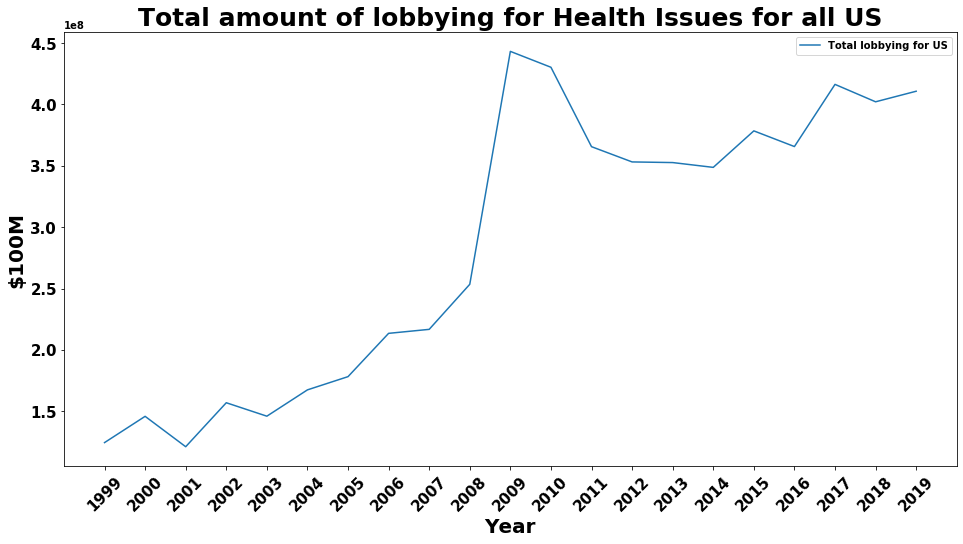

In [26]:

plt.figure(figsize=(16,8))
plt.title('Total amount of lobbying for Health Issues for all US', fontsize = 25)
plt.plot(data2.year,data2['Total_amount'], label = 'Total lobbying for US')
plt.xlabel('Year',fontsize=20)
plt.ylabel('$100M',fontsize=20)
plt.xticks(data2.year,fontsize=15, rotation = 45)
plt.yticks(fontsize=15)
plt.legend(loc='best');


In [27]:
#########
# Correlation of Lobbying vs hearlthcare charges

x = data[data['ave_data'].str.contains("ave_charged")]['USall']
y = data2[data2['year'].between(2011, 2017)]['US_amount']
scipy.stats.pearsonr(x, y)


(0.7577422665439904, 0.048453539473213396)

In [28]:
def my_statelobby1(state5,state6):
    plt.figure(figsize=(16,8))
    plt.title(f'Comparing healthcare lobbying for {state5} and {state6} (US Senate)', fontsize=25)
    plt.plot(data2.year, data2[f'{state5}amount'],
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state5} total lobbying')

    plt.plot(data2.year, data2[f'{state6}amount'],
             color = 'orange',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state6} total lobbying')
                                          
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Paid to lobbyists ($10M)',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
state_select5 = widget.Select(
    options=my_states,
    value='AL',
    description='State1:',
    )
    
state_select6 = widget.Select(
    options=my_states,
    value='CT',
    description='State2:',
    )    

widget.interact(my_statelobby1, state5=state_select5, state6= state_select6)   

interactive(children=(Select(description='State1:', index=1, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT'…

<function __main__.my_statelobby1(state5, state6)>

In [29]:
def my_statelobby2(state7,state8):
    plt.figure(figsize=(16,8))
    plt.title(f'Comparing healthcare lobbying per capita for {state7} and {state8} (US Senate)', fontsize=25)
 
    plt.plot(data2.year, data2[f'{state7}per_cap'],
             color = 'lightgreen',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state7} per capita lobbying')

    plt.plot(data2.year, data2[f'{state8}per_cap'],
             color = 'orange',
             linestyle = 'dotted',
             marker = 'o',
             label = f'{state8} per capita lobbying')
                                          
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Paid to lobbyists ($ percapita)',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best');
    
state_select7 = widget.Select(
    options=my_states,
    value='AL',
    description='State1:',
    )
    
state_select8 = widget.Select(
    options=my_states,
    value='CT',
    description='State2:',
    )    

widget.interact(my_statelobby2, state7=state_select7, state8= state_select8)   

interactive(children=(Select(description='State1:', index=1, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT'…

<function __main__.my_statelobby2(state7, state8)>